# Задача 3. Сравнение методов классификации

* **Дедлайн**: 30.04.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [ ] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [ ] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, decision tree**).
- [ ] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Чтение данных

In [2]:
df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Возьмём данные заболеваний сердца у пациентов, которые можно скачать [тут](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data).

Описание датасета: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

## EDA

In [3]:
df.target.value_counts()

target
1    526
0    499
Name: count, dtype: int64

Примерно равное количество больных и здоровых

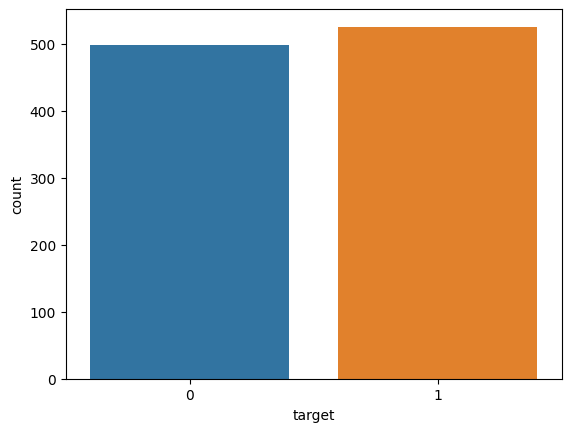

In [4]:
sns.countplot(x="target", data=df)
plt.show()

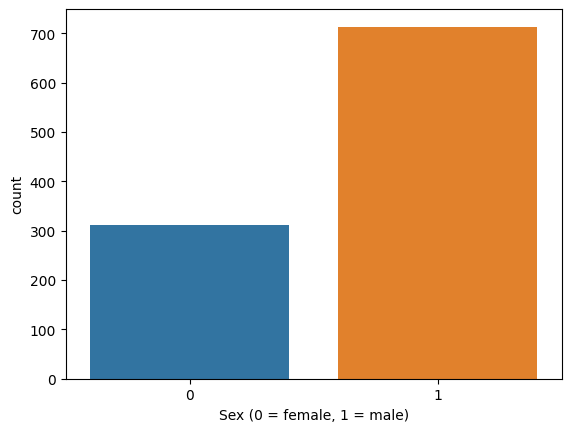

In [5]:
sns.countplot(x='sex', data=df)
plt.xlabel("Sex (0 = female, 1 = male)")
plt.show()

In [6]:
print(df['sex'].value_counts(normalize=True))

sex
1    0.69561
0    0.30439
Name: proportion, dtype: float64


Мужчин больше - неравномерность данных. Модели типа Random Forest / XGBoost устойчивы к дисбалансу в признаках, посмотрим насколько sex влияет на target

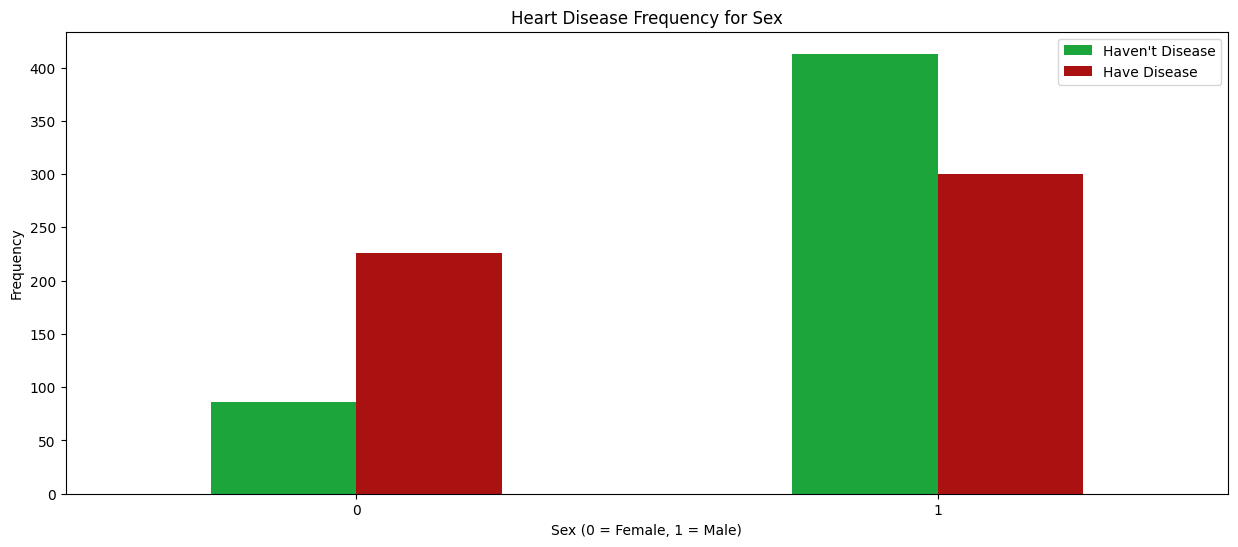

In [7]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

Влияние сильное, будет интересно реализовать модель Random Forest. Также буду реализовывать модель Naive Bayes, так как мы его не разбирали.

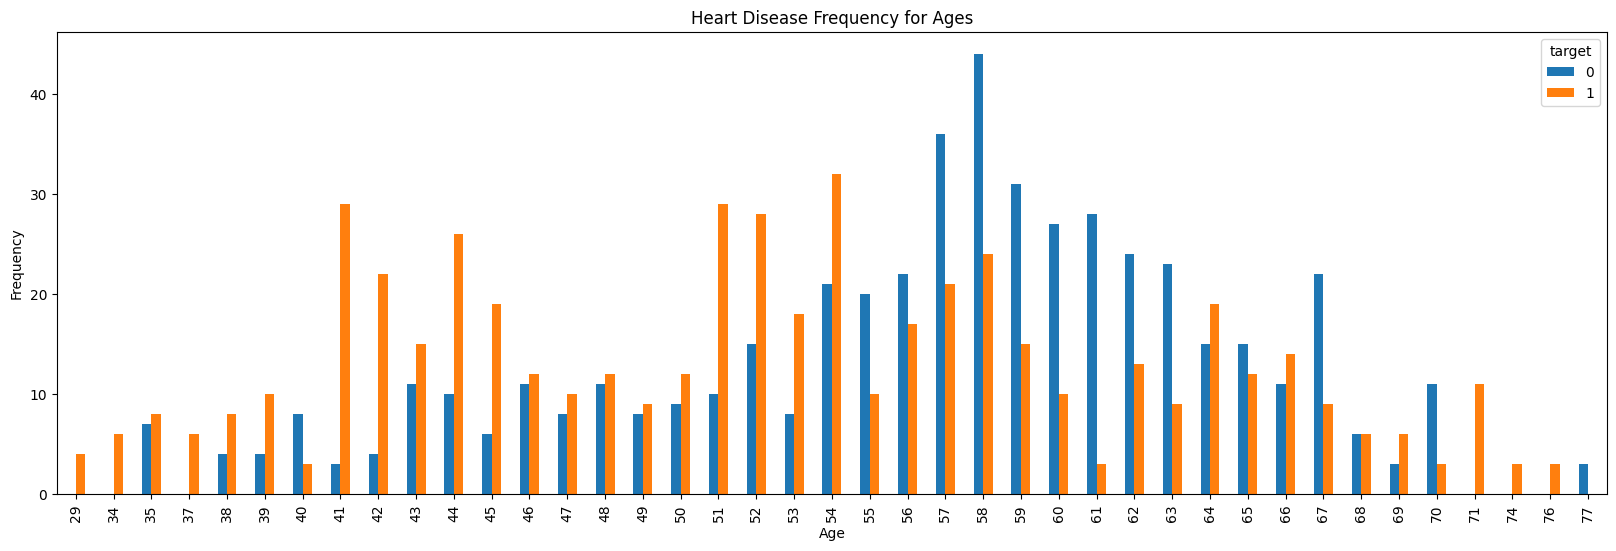

In [8]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Довольно сложная зависимость, не будем переводить age в категориальный признак

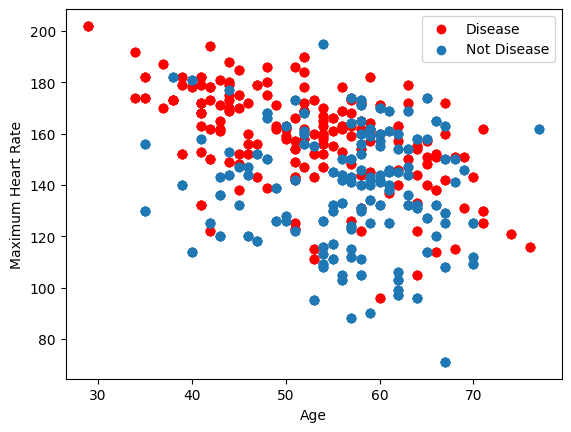

In [9]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

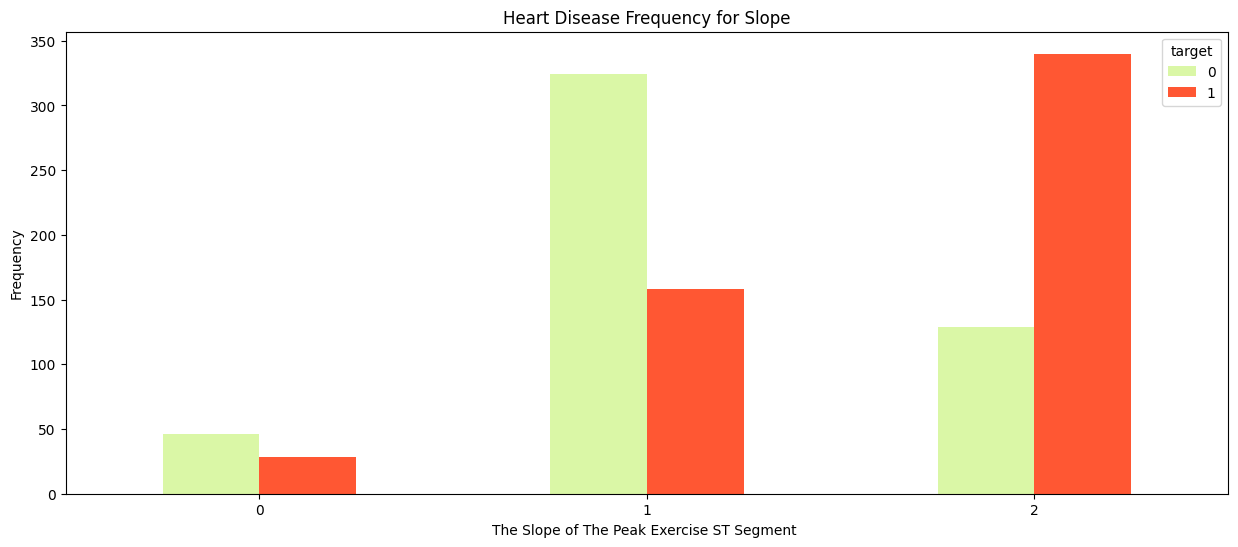

In [10]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

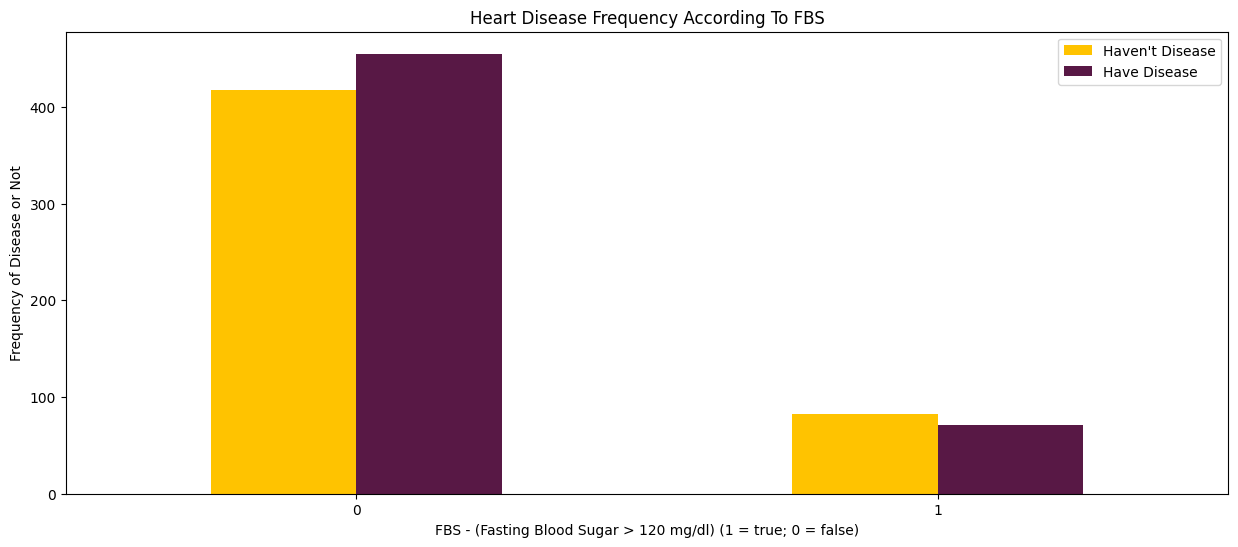

In [11]:
pd.crosstab(df.fbs,df.target).plot(kind="bar", figsize=(15, 6), color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Как видим fbs не сильно влияет на целевой признак - можем его удалить из набора.

In [12]:
df = df.drop(['fbs'], axis = 1)

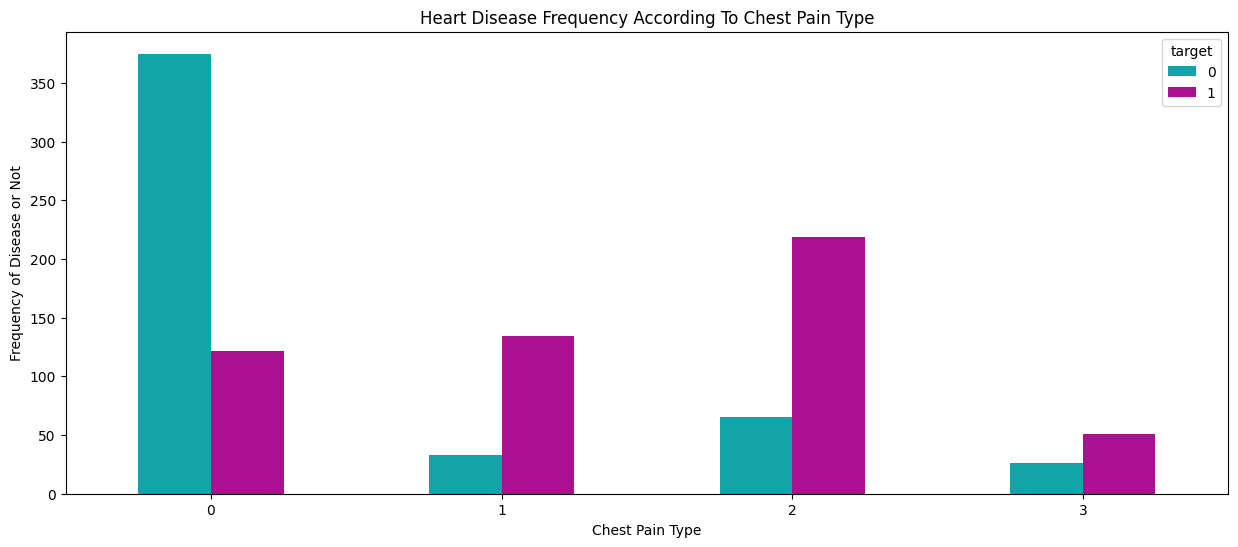

In [13]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

Заметна сильная разница между 0 chest pain type и остальными (1,2,3)

### Преобразование категориальных признаков

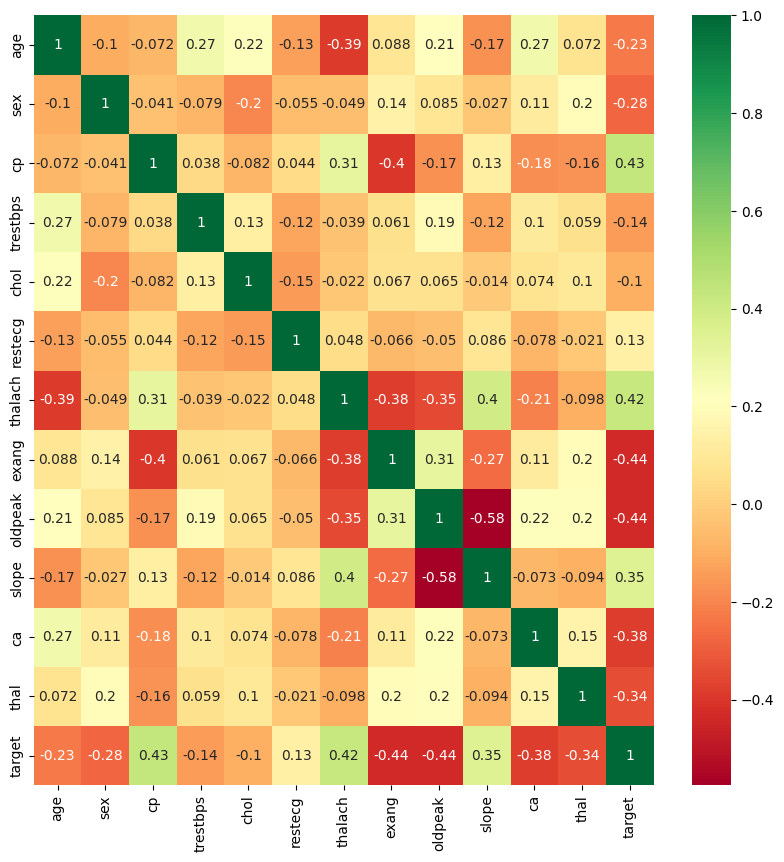

In [14]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

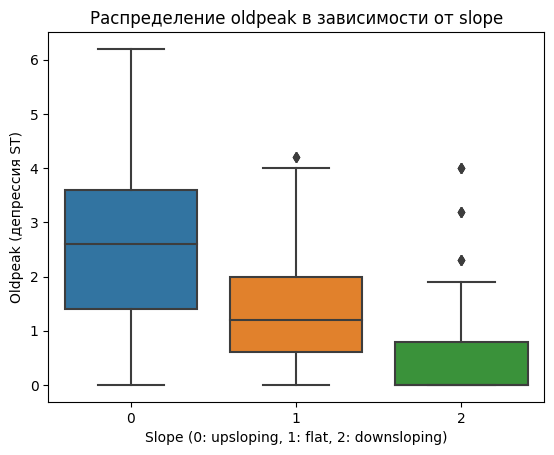

In [15]:
sns.boxplot(x='slope', y='oldpeak', data=df)
plt.title("Распределение oldpeak в зависимости от slope")
plt.xlabel("Slope (0: upsloping, 1: flat, 2: downsloping)")
plt.ylabel("Oldpeak (депрессия ST)")
plt.show()

Видим линейную зависимость.\
Создадим новую категориальную переменную:
- Можно разбить oldpeak на интервалы (например: низкий, средний, высокий)
- Затем объединить информацию с slope в одну переменную

In [16]:
# Разбиваем oldpeak на категории (можно настроить границы)
df['oldpeak_cat'] = pd.cut(df['oldpeak'], 
                           bins=[-1, 0.5, 1.5, float('inf')], 
                           labels=['low', 'medium', 'high'])

# Объединяем slope и oldpeak_cat в одну переменную
df['slope_oldpeak'] = df['slope'].astype(str) + '_' + df['oldpeak_cat'].astype(str)

# Удаляем столбцы 'slope' и 'oldpeak'
df = df.drop(['slope', 'oldpeak', 'oldpeak_cat'], axis=1)

# Проверяем результат
df.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,ca,thal,target,slope_oldpeak
0,52,1,0,125,212,1,168,0,2,3,0,2_medium
1,53,1,0,140,203,0,155,1,0,3,0,0_high
2,70,1,0,145,174,1,125,1,0,3,0,0_high
3,61,1,0,148,203,1,161,0,1,3,0,2_low
4,62,0,0,138,294,1,106,0,3,2,0,1_high


Закодируем категориальные признаки **cp**, **thal** и **slope_oldpeak**. (One-Hot Encoding)

In [17]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope_oldpeak'], prefix = "slope_oldpeak")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,ca,thal,...,thal_3,slope_oldpeak_0_high,slope_oldpeak_0_low,slope_oldpeak_0_medium,slope_oldpeak_1_high,slope_oldpeak_1_low,slope_oldpeak_1_medium,slope_oldpeak_2_high,slope_oldpeak_2_low,slope_oldpeak_2_medium
0,52,1,0,125,212,1,168,0,2,3,...,True,False,False,False,False,False,False,False,False,True
1,53,1,0,140,203,0,155,1,0,3,...,True,True,False,False,False,False,False,False,False,False
2,70,1,0,145,174,1,125,1,0,3,...,True,True,False,False,False,False,False,False,False,False
3,61,1,0,148,203,1,161,0,1,3,...,True,False,False,False,False,False,False,False,True,False
4,62,0,0,138,294,1,106,0,3,2,...,False,False,False,False,True,False,False,False,False,False


In [18]:
df = df.drop(columns = ['cp', 'thal', 'slope_oldpeak'])
df.head()

,age,sex,trestbps,chol,restecg,thalach,exang,ca,target,cp_0,...,thal_3,slope_oldpeak_0_high,slope_oldpeak_0_low,slope_oldpeak_0_medium,slope_oldpeak_1_high,slope_oldpeak_1_low,slope_oldpeak_1_medium,slope_oldpeak_2_high,slope_oldpeak_2_low,slope_oldpeak_2_medium
0,52,1,125,212,1,168,0,2,0,True,...,True,False,False,False,False,False,False,False,False,True
1,53,1,140,203,0,155,1,0,0,True,...,True,True,False,False,False,False,False,False,False,False
2,70,1,145,174,1,125,1,0,0,True,...,True,True,False,False,False,False,False,False,False,False
3,61,1,148,203,1,161,0,1,0,True,...,True,False,False,False,False,False,False,False,True,False
4,62,0,138,294,1,106,0,3,0,True,...,False,False,False,False,True,False,False,False,False,False


## Разбиение данных с использованием train_test_split и масштабирование

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

Реализую модели. Сначала NaiveBayes

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from collections import defaultdict

In [21]:
class MyNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, h=1.0, alpha=1.0, kernel='uniform'):
        """
        h - ширина окна для непрерывных признаков
        alpha - параметр сглаживания для категориальных признаков
        kernel: 'uniform' или 'parzen'
        """
        self.h = h
        self.alpha = alpha
        self.kernel = kernel
        
    def get_params(self, deep=True): # Для совместимости с scikit-learn
        return {
            'h': self.h,
            'alpha': self.alpha,
            'kernel': self.kernel
        }
    
    def set_params(self, **params): # Для совместимости с scikit-learn
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def _kernel_func(self, u):
        if self.kernel == 'uniform':
            return (np.abs(u) <= 1).astype(float)
        elif self.kernel == 'parzen':
            return np.maximum(0, 1 - np.abs(u))
    
    def _estimate_density(self, x, samples):
        n = len(samples)
        u = (x - samples) / self.h
        return np.sum(self._kernel_func(u)) / (2 * n * self.h)

    def _detect_feature_types(self, X):
        n_features = X.shape[1]
        types = []
        for i in range(n_features):
            if (X[:, i] == X[:, i].astype(int)).all() and len(np.unique(X[:, i])) < 20:
                types.append('categorical')
            else:
                types.append('continuous')
        return types

    def fit(self, X, y):
        X, y = check_X_y(X, y)  # Проверка входных данных
        self.classes_ = np.unique(y)  # Для совместимости с scikit-learn
        n_samples = X.shape[0]
        
        self.feature_types_ = self._detect_feature_types(X)
        self.class_probs_ = {c: np.sum(y == c) / n_samples for c in self.classes_}
        self.train_data_ = {}
        self.category_counts_ = defaultdict(dict)
        
        for c in self.classes_:
            X_c = X[y == c]
            self.train_data_[c] = X_c
            
            for i, f_type in enumerate(self.feature_types_):
                if f_type == 'categorical':
                    values, counts = np.unique(X_c[:, i], return_counts=True)
                    self.category_counts_[c][i] = dict(zip(values, counts))
        
        return self  # Для совместимости с pipeline

    def predict(self, X):
        check_is_fitted(self)  # Проверка что модель обучена
        X = check_array(X)  # Проверка входных данных
        
        predictions = []
        for x in X:
            max_prob = -1
            best_class = None
            
            for c in self.classes_:
                prob = self.class_probs_[c]
                
                for i, f_type in enumerate(self.feature_types_):
                    if f_type == 'continuous':
                        samples = self.train_data_[c][:, i]
                        prob *= self._estimate_density(x[i], samples)
                    else:
                        counts = self.category_counts_[c].get(i, {})
                        total = sum(counts.values())
                        n_categories = len(counts)
                        count = counts.get(x[i], 0)
                        prob *= (count + self.alpha) / (total + self.alpha * n_categories)

                # Выбираем класс с максимальной вероятностью
                if prob > max_prob:
                    max_prob = prob
                    best_class = c
            
            predictions.append(best_class)
        
        return np.array(predictions)

**Инициализация** (`__init__`):
   - Задаем основные параметры модели

**Служебные методы** (`get_params`, `set_params`):
   - Нужны для интеграции с scikit-learn

**Методы оценки плотности** (`_kernel_func`, `_estimate_density`):
   - Реализуют ядерные методы оценки

**Определение типов признаков** (`_detect_feature_types`):
   - Автоматически определяет какие признаки категориальные

**Обучение** (`fit`):
   - Запоминает статистики по данным
   - Считает вероятности классов
   - Для категориальных - частоты значений

**Предсказание** (`predict`):
   - Для каждого объекта вычисляет вероятность для каждого класса
   - Использует наивное предположение о независимости признаков
   - Возвращает наиболее вероятный класс

Теперь Random Forest модель

In [22]:
class MyRandomForest(BaseEstimator):
    def __init__(self, n_estimators=100, max_depth=None, max_features='auto', 
                 random_state=None, task_type='classification'):
        """
        Параметры:
        ----------
        task_type : 'classification' или 'regression'
        max_features : 'auto' (sqrt(n) для классификации, n/3 для регрессии),
                      'sqrt', 'log2', int или float
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.task_type = task_type
        
        if random_state is not None:
            np.random.seed(random_state)

    def _detect_feature_types(self, X):
        n_features = X.shape[1]
        types = []
        for i in range(n_features):
            if (X[:, i] == X[:, i].astype(int)).all() and len(np.unique(X[:, i])) < 20:
                types.append('categorical')
            else:
                types.append('continuous')
        return types

    def _resolve_max_features(self, n_features):
        if isinstance(self.max_features, str):
            if self.max_features == 'auto':
                if self.task_type == 'classification':
                    return max(1, int(np.sqrt(n_features)))  # sqrt(n) для классификации
                else:
                    return max(1, int(n_features / 3))       # n/3 для регрессии
            elif self.max_features == 'sqrt':
                return max(1, int(np.sqrt(n_features)))
            elif self.max_features == 'log2':
                return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            return max(1, min(n_features, self.max_features))
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        return n_features

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_ = X.shape[1]
        self.feature_types_ = self._detect_feature_types(X)
        
        # Определяем max_features
        effective_max_features = self._resolve_max_features(self.n_features_)
        
        # Выбираем тип дерева
        Tree = DecisionTreeClassifier if self.task_type == 'classification' else DecisionTreeRegressor
        
        self.estimators_ = []
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            tree = Tree(
                max_depth=self.max_depth,
                max_features=effective_max_features,
                random_state=np.random.randint(1e6))
            tree.fit(X_sample, y_sample)
            self.estimators_.append(tree)
        
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        # Для классификации - голосование, для регрессии - усреднение
        if self.task_type == 'classification':
            preds = np.array([tree.predict(X) for tree in self.estimators_])
            return np.array([np.bincount(preds[:, i]).argmax() for i in range(len(X))])
        else:
            return np.mean([tree.predict(X) for tree in self.estimators_], axis=0)

In [23]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Функция для сравнения моделей
def compare_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=4000, random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            },
            'scale': True
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'gamma': ['scale', 'auto']
            },
            'scale': True
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9, 11],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            },
            'scale': True
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10]
            },
            'scale': False
        },
        'Naive Bayes': { 
            'model': GaussianNB(),
            'params': {
                'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
            },
            'scale': False
        },
        'My Naive Bayes': {
            'model': MyNaiveBayes(),
            'params': {
                'h': [0.5, 1.0],
                'alpha': [0.5, 1.0],
                'kernel': ['uniform', 'parzen']
            },
            'scale': False
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5],
                'max_features': ['sqrt', 'log2']
            },
            'scale': False
        },
        'My Random Forest': {
            'model': MyRandomForest(task_type='classification', random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2']
            },
            'scale': False
        }
    }

    results = {}
    best_models = {}
    
    for name, config in models.items():
        print(f"\n=== {name} ===")
        
        # Выбираем данные (масштабированные или нет)
        if config['scale']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test
        
        # Поиск по сетке параметров
        gs = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1, scoring='accuracy')
        gs.fit(X_tr, y_train)

        # Сохраняем лучшую модель
        best_model = gs.best_estimator_
        best_models[name] = best_model
        
        # Оценка качества
        cv_score = cross_val_score(best_model, X_tr, y_train, cv=5, scoring='accuracy').mean()
        y_pred = best_model.predict(X_te)
        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Сохраняем результаты
        results[name] = {
            'best_params': gs.best_params_,
            'cv_accuracy': cv_score,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'model': best_model
        }
        
        print(f"Best params: {gs.best_params_}")
        print(f"CV Accuracy: {cv_score:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1: {test_f1:.4f}")
    
    return results, best_models

# # Перебор моделей и параметров
# best_models = {}
# scaled_models = ['Logistic Regression', 'SVM', 'KNN']  # Модели, для которых нужно масштабирование

# Запуск сравнения
results, best_models = compare_models(X_train, X_test, y_train, y_test)

# Вывод итоговой таблицы
print("\n=== Итоговое сравнение моделей ===")
print("{:<25} {:<15} {:<15} {:<15}".format(
    "Model", "CV Accuracy", "Test Accuracy", "Test F1"))
print("-" * 65)
for name, res in results.items():
    print("{:<25} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        name, res['cv_accuracy'], res['test_accuracy'], res['test_f1']))


=== Logistic Regression ===
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
CV Accuracy: 0.8633
Test Accuracy: 0.8182
Test F1: 0.8180

=== SVM ===
Best params: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
CV Accuracy: 0.9596
Test Accuracy: 0.9708
Test F1: 0.9707

=== KNN ===
Best params: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
CV Accuracy: 0.9777
Test Accuracy: 0.9805
Test F1: 0.9805

=== Decision Tree ===
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
CV Accuracy: 0.9693
Test Accuracy: 0.9610
Test F1: 0.9609

=== Naive Bayes ===
Best params: {'var_smoothing': 1e-06}
CV Accuracy: 0.8201
Test Accuracy: 0.7695
Test F1: 0.7693

=== My Naive Bayes ===
Best params: {'alpha': 0.5, 'h': 0.5, 'kernel': 'uniform'}
CV Accuracy: 0.8995
Test Accuracy: 0.8994
Test F1: 0.8992

=== Random Forest ===
Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
CV Accuracy: 0.9749
Test Accu

In [24]:
# Выбор лучшей модели по точности на тесте
scaled_models = ['Logistic Regression', 'SVM', 'KNN']
best_model_name = max(best_models, key=lambda x: accuracy_score(y_test, best_models[x].predict(X_test_scaled if x in scaled_models else X_test)))
print(f"\nBest model is {best_model_name} with accuracy {accuracy_score(y_test, best_models[best_model_name].predict(X_test_scaled if best_model_name in scaled_models else X_test)):.4f}")


Best model is KNN with accuracy 0.9805


## Confusion Matrix

In [25]:
# Predicted values
y_head_lr = results['Logistic Regression']['model'].predict(X_test_scaled)
y_head_knn = results['KNN']['model'].predict(X_test_scaled)
y_head_svm = results['SVM']['model'].predict(X_test_scaled)
y_head_dt = results['Decision Tree']['model'].predict(X_test)
y_head_nb = results['Naive Bayes']['model'].predict(X_test)
y_head_mynb = results['My Naive Bayes']['model'].predict(X_test)
y_head_rf = results['Random Forest']['model'].predict(X_test)
y_head_myrf = results['My Random Forest']['model'].predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_dt = confusion_matrix(y_test, y_head_dt)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_mynb = confusion_matrix(y_test, y_head_mynb)
cm_rf = confusion_matrix(y_test, y_head_rf)
cm_myrf = confusion_matrix(y_test, y_head_myrf)

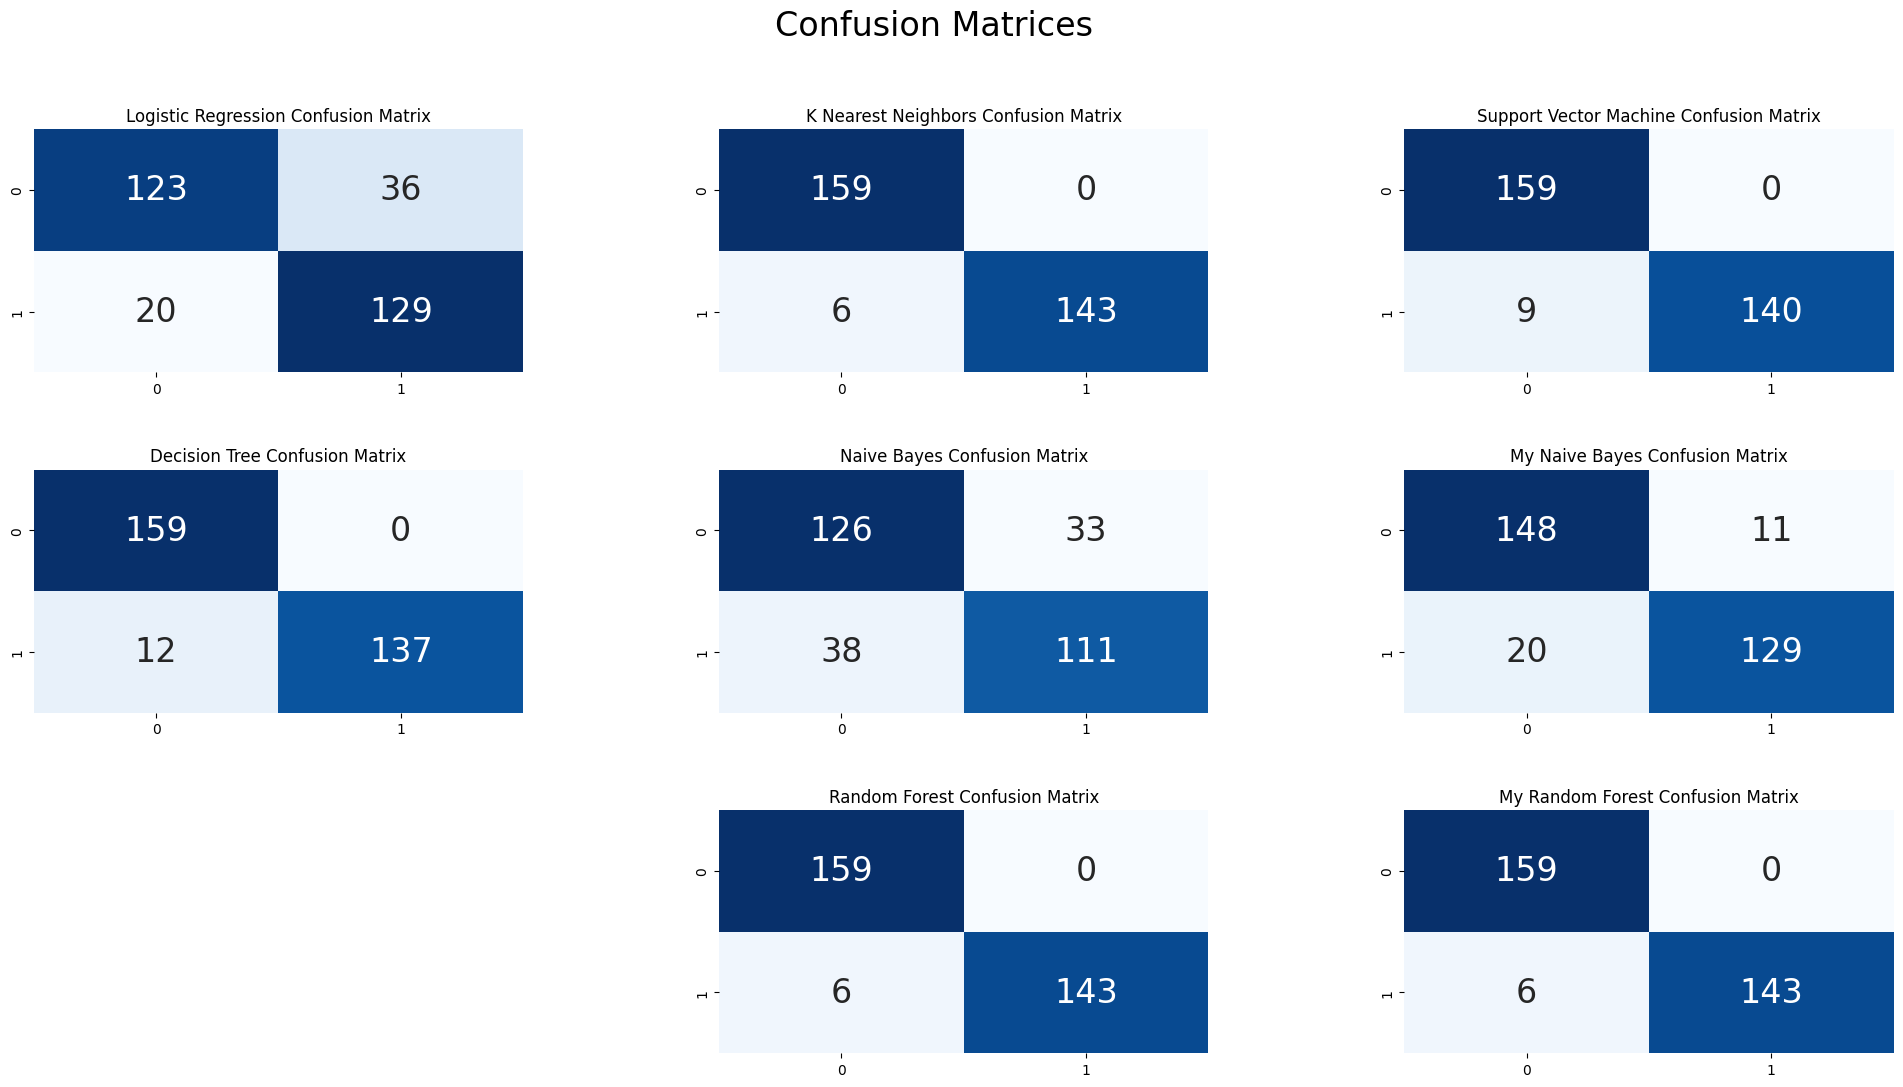

In [27]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Decision Tree Confusion Matrix")
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("My Naive Bayes Confusion Matrix")
sns.heatmap(cm_mynb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,8)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,9)
plt.title("My Random Forest Confusion Matrix")
sns.heatmap(cm_myrf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Как видим, моя реализация **Nauve Bayes** лучше работает на этих данных, чем реализация из библиотеки *scikit-learn*.
Также моя модель **Random Forest** получилась с такой *confusion matrix*, как из *scikit-learn*.
Для данной задачи лучше подошли модели - **К Nearest Neighbors** и **Random Forest**.